In [16]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np
import numpy.random as random
from matplotlib.gridspec import GridSpec
from astropy.table import Table


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
def z_n(phase, n=2, norm=1):
    '''Z^2_n statistics, a` la Buccheri+03, A&A, 128, 245, eq. 2.
    
    http://adsabs.harvard.edu/abs/1983A%26A...128..245B
    
    Parameters
    ----------
    phase : array of floats
        The phases of the events
    n : int, default 2
        The ``n`` in $Z^2_n$.

    Other Parameters
    ----------------
    norm : float or array of floats
        A normalization factor that gets multiplied as a weight.

    Returns
    -------
    z2_n : float
        The Z^2_n statistics of the events.
    '''
    nbin = len(phase)

    if nbin == 0:
        return 0

    norm = np.asarray(norm)
    if norm.size == 1:
        total_norm = nbin * norm
    else:
        total_norm = np.sum(norm)
    phase = phase * 2 * np.pi
    return 2 / total_norm * \
        np.sum([np.sum(np.cos(k * phase) * norm) ** 2 +
                np.sum(np.sin(k * phase) * norm) ** 2
                for k in range(1, n + 1)])
    

def get_z2n_from_profile(profile, n=2):
    phase = np.arange(0, 1, 1 / len(profile))
    return z_n(phase, norm=profile, n=n)


def get_Htest_from_profile(profile, nmax=20):
    """Calculate the H-test 
    
    http://adsabs.harvard.edu/abs/1989A&A...221..180D
    https://arxiv.org/pdf/1005.4867.pdf
    """
    phase = np.arange(0, 1, 1 / len(profile))
    z_values = np.zeros(nmax)
    for n in range(1, nmax + 1):
        z_values[n - 1] = z_n(phase, n=n, norm=profile) - 4 * n + n
    
    return np.max(z_values)


def gaussian_periodic(x, x0, amp, width):
    '''Approximates a Gaussian periodic function by summing the contributions in the phase
    range 0--1 with those in the phase range -1--0 and 1--2'''
    # Phase is always between 0 and 1
    phase = x - np.floor(x)
    lc = np.zeros_like(x)
    for shift in [-1, 0, 1]:
        lc += amp * np.exp(-(phase + shift - x0)**2 / width ** 2)
        
    return lc


def generate_profile(total_phase, ngauss=None, ph0=0.1, amp=1, width=0.05):
    if ngauss is None:
        ngauss = random.randint(1, 3)
    lc = np.zeros_like(total_phase)
    for i in range(ngauss):
        if i > 0:
            ph0 = random.uniform(0, 1)
            amp = random.uniform(0.1 * amp, amp)
            width = random.uniform(0.01, 0.2)
        lc += gaussian_periodic(total_phase, ph0, amp, width)
    
    return lc


In [3]:
import inspect
from scipy.ndimage import gaussian_filter
def generate_dispersed_profile(pulse_freq=500, start_freq=1400, bandwidth=258, 
                               nchan=128, dm=None, amp=None, width=None, 
                               ph0=None, nbin=128, noise_level=None):

    local_vars = locals()
    
    info = type('info', (object,), {})
    for a, v in local_vars.items():
        setattr(info, a, v)
        
    if ph0 is None:
        info.ph0 = random.uniform(0, 1)
    if amp is None:
        info.amp = random.uniform(0.1, 1)
    if width is None:
        info.width = random.uniform(0.01, 0.2)
    if noise_level is None:
        info.noise_level = random.uniform(0, 1)
    if dm is None:
        info.dm = random.uniform(0, 500)
    if pulse_freq is None:
        info.pulse_freq = random.uniform(50, 750)

    phases = np.arange(0, 1, 1/info.nbin)
    prof = generate_profile(phases, 2, info.ph0, info.amp, info.width) / info.nchan
    allprofs = np.tile(prof, (info.nchan, 1))
    allprofs += np.random.normal(allprofs, info.noise_level / info.nchan)
    profile = np.sum(allprofs, axis=0)
    dfreq = info.bandwidth / info.nchan
    stop_freq = info.start_freq + info.bandwidth
    ref_delay = 4.5e3 * info.dm * stop_freq**(-2)
    for i, p in enumerate(allprofs):
        # DM delay
        chan_freq = info.start_freq + i * dfreq
        delay = 4.5e3 * info.dm * chan_freq ** (-2) - ref_delay
        # DM broadening inside each channel
        broadening = 8.3 * info.dm * dfreq * (chan_freq / 1000) ** (-3) * 1e-6
        window = broadening * info.pulse_freq // info.nbin
        if window > 1:
            p = gaussian_filter(p, window)
            
        dph = int(np.rint(delay * info.pulse_freq))
        allprofs[i, :] = np.roll(p, dph) 
    info.dedisp_profile = profile
    info.allprofs = allprofs
    info.disp_profile = np.sum(allprofs, axis=0)

    info.disp_z2 = get_z2n_from_profile(info.disp_profile, n=2)
    info.disp_z6 = get_z2n_from_profile(info.disp_profile, n=6)
    info.disp_z12 = get_z2n_from_profile(info.disp_profile, n=12)
    info.disp_z20 = get_z2n_from_profile(info.disp_profile, n=20)
    info.disp_H = get_Htest_from_profile(info.disp_profile)
    
    info.dedisp_z2 = get_z2n_from_profile(info.dedisp_profile, n=2)
    info.dedisp_z6 = get_z2n_from_profile(info.dedisp_profile, n=6)
    info.dedisp_z12 = get_z2n_from_profile(info.dedisp_profile, n=12)
    info.dedisp_z20 = get_z2n_from_profile(info.dedisp_profile, n=20)
    info.dedisp_H = get_Htest_from_profile(info.dedisp_profile)
    return info
    

In [4]:
def print_info_to_table(info):
    from astropy.table import Table
    
    info_dict = {}
    
    for key, value in dict(info.__dict__).items():
        if not key.startswith("__"):
            info_dict[key] = [value]
    table = Table(info_dict)
    return table


def plot_profile(info):
    profile = info.dedisp_profile
    disp_profile = info.disp_profile
    allprofs = info.allprofs
    start_freq = info.start_freq
    bandwidth = info.bandwidth
    pulse_freq = info.pulse_freq

    plt.figure(figsize=(15, 15))
    gs = GridSpec(3, 1, height_ratios=(1, 2, 1), hspace=0)
    aximg = plt.subplot(gs[1])
    axprof = plt.subplot(gs[0], sharex=aximg)
    axdisp = plt.subplot(gs[2], sharex=aximg)

    phases = np.arange(0, 1, 1/len(profile))
    aximg.imshow(allprofs, aspect="auto", origin="lower",
                 extent=(0, 1, start_freq, start_freq + bandwidth))
    axprof.plot(phases, profile, drawstyle='steps')
    axdisp.plot(phases, disp_profile, drawstyle='steps')
    aximg.set_xlim((0, 1))
    aximg.set_ylabel("Frequency (MHz)")
    axprof.set_ylabel("Dedispersed profile")
    axdisp.set_ylabel("Dispersed profile")
    axdisp.set_xlabel("Phase")
    aximg.text(0.5, 0.5, 
               "DM={:.1f}\n$\\nu={:.1f}$ Hz\nH-test={:.1f} -> {:.1f}".format(info.dm, 
                                                                   info.pulse_freq,
                                                                   info.disp_H,
                                                                   info.dedisp_H), 
               horizontalalignment='center',
               verticalalignment='center', transform=aximg.transAxes, 
               fontsize=40, color='white')


noise_level,nbin,ph0,width,amp,dm,nchan,bandwidth,start_freq,pulse_freq,dedisp_profile [128],"allprofs [128,128]",disp_profile [128],disp_z2,disp_z6,disp_z12,disp_z20,disp_H,dedisp_z2,dedisp_z6,dedisp_z12,dedisp_z20,dedisp_H
int64,int64,float64,float64,float64,int64,int64,int64,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
1,128,0.1,0.03,0.6915612788502706,400,128,256,1400,682.9564011810868,0.477893654343901 .. 0.644091826917016,-0.007238590832929353 .. 0.006295947812794975,0.28423448306962634 .. 0.25081231717513425,1.7319242179637482,2.2643513886579254,2.940438299075357,3.6225957754795557,-1.4887433686636804,46.7286402799138,59.758402711239036,68.59411481411533,70.1787921403401,41.758402711239036


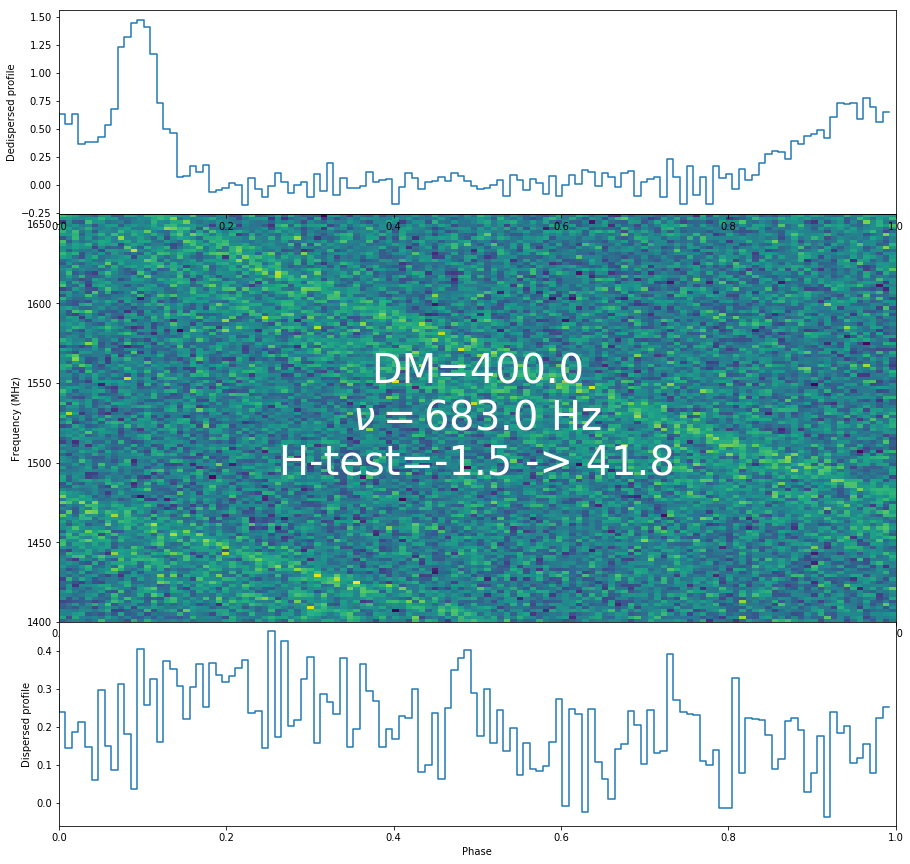

In [5]:
start_freq=1400
bandwidth=256
pulse_freq = None

info = generate_dispersed_profile(pulse_freq=pulse_freq,
                                  start_freq=start_freq, 
                                  bandwidth=bandwidth,
                                  noise_level=1,
                                  ph0=0.1, width=0.03, 
                                  dm=400, nbin=128)
plot_profile(info)
print_info_to_table(info)

noise_level,nbin,ph0,width,amp,dm,nchan,bandwidth,start_freq,pulse_freq,dedisp_profile [128],"allprofs [128,128]",disp_profile [128],disp_z2,disp_z6,disp_z12,disp_z20,disp_H,dedisp_z2,dedisp_z6,dedisp_z12,dedisp_z20,dedisp_H
int64,int64,float64,float64,float64,float64,int64,int64,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
1,128,0.1,0.03,0.4436832595721598,236.256598555435,128,256,1400,715.0602029485674,-0.04308320328518115 .. -0.0829531947342224,0.012751928010678613 .. -0.007468148347281682,0.11126673061109268 .. 0.24462654789340257,0.26740118645278615,1.2701133726535734,1.7314095576142623,2.1600254785630666,-2.8198782112936467,11.121310905848368,21.34372638629343,27.46570070081546,28.785225114959577,6.951615775298219


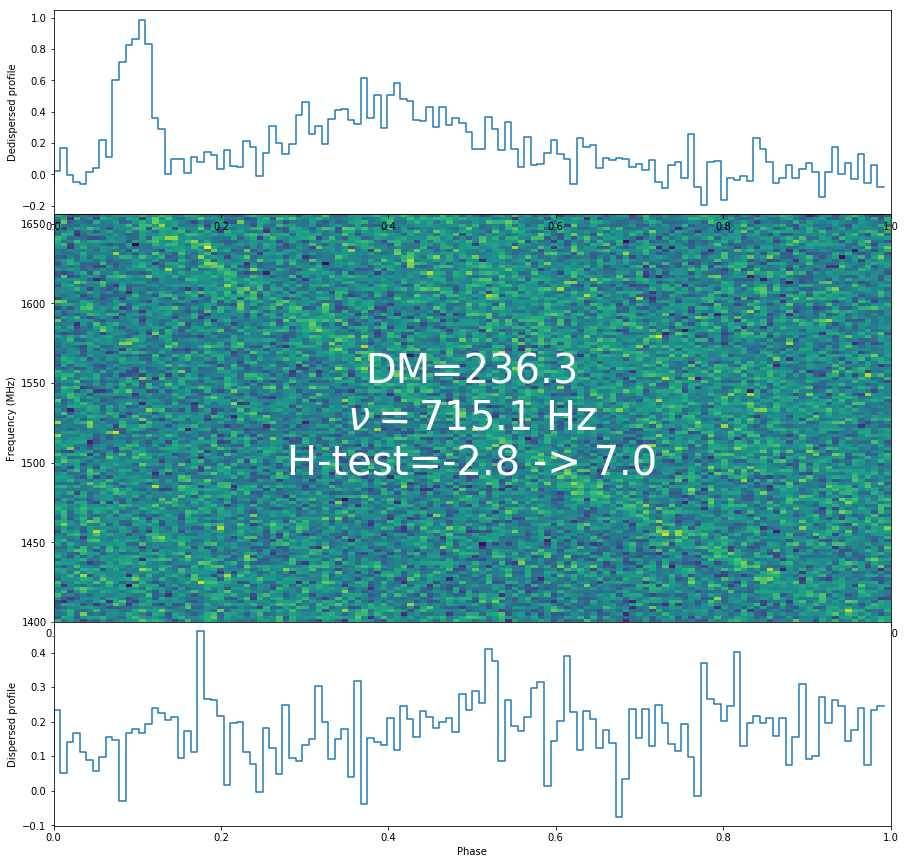

In [6]:
info = generate_dispersed_profile(pulse_freq=pulse_freq,
                                  start_freq=start_freq, 
                                  bandwidth=bandwidth,
                                  noise_level=1,
                                  ph0=0.1, width=0.03)
plot_profile(info)
print_info_to_table(info)

noise_level,nbin,ph0,width,amp,dm,nchan,bandwidth,start_freq,pulse_freq,dedisp_profile [128],"allprofs [128,128]",disp_profile [128],disp_z2,disp_z6,disp_z12,disp_z20,disp_H,dedisp_z2,dedisp_z6,dedisp_z12,dedisp_z20,dedisp_H
int64,int64,float64,float64,float64,float64,int64,int64,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
1,128,0.1,0.03,0.5190359169415857,305.6920864806884,128,256,1400,665.7384734407434,-0.10161784609492733 .. -0.07440550178288009,-0.012890365117824761 .. 0.0008648691363166189,0.07331465791070438 .. 0.10637893975590443,0.5273011950221997,2.928789845582006,3.8418658377408614,6.517310634196323,-2.6951402198679135,20.798719024515115,57.14270496779428,72.22586503105009,78.1341761979379,43.682897929887474


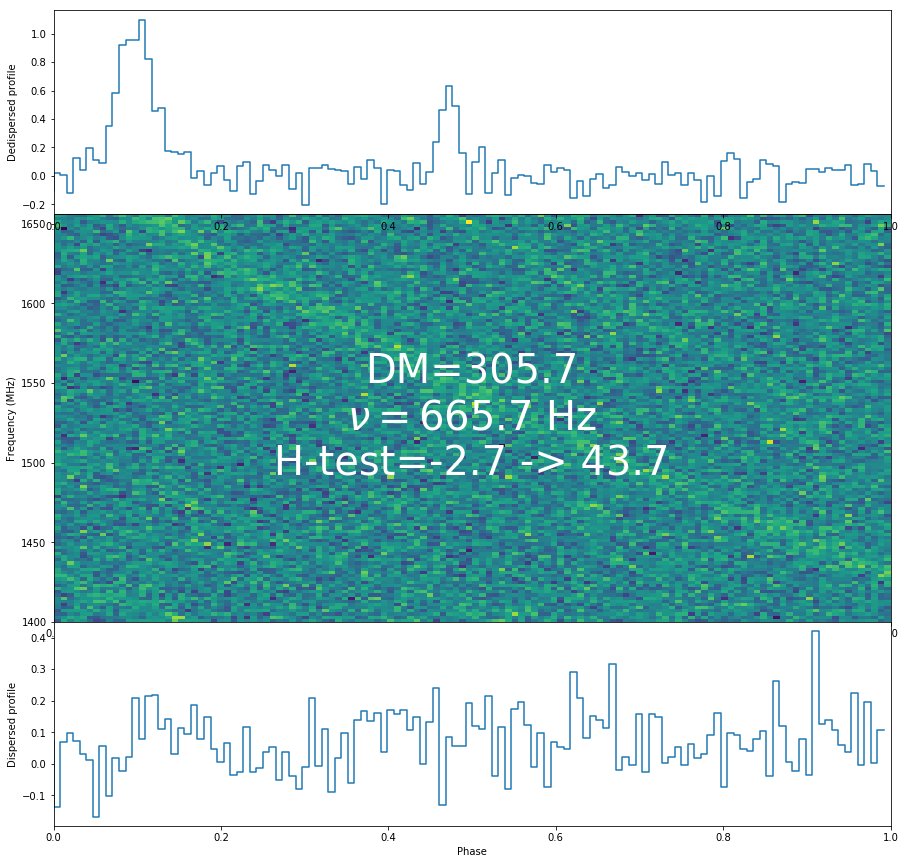

In [7]:
info = generate_dispersed_profile(pulse_freq=pulse_freq,
                                  start_freq=start_freq, 
                                  bandwidth=bandwidth,
                                  noise_level=1,
                                  ph0=0.1, width=0.03)
plot_profile(info)
print_info_to_table(info)

noise_level,nbin,ph0,width,amp,dm,nchan,bandwidth,start_freq,pulse_freq,dedisp_profile [128],"allprofs [128,128]",disp_profile [128],disp_z2,disp_z6,disp_z12,disp_z20,disp_H,dedisp_z2,dedisp_z6,dedisp_z12,dedisp_z20,dedisp_H
int64,int64,float64,float64,float64,float64,int64,int64,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
1,128,0.1,0.03,0.7743415501552949,37.71493797388631,128,256,1400,497.50380708045435,0.2810218124626497 .. 0.25182862440162673,0.0030853350446614905 .. -0.0003019724758194808,0.17886680250071874 .. 0.30786107537984797,41.59886560903262,55.495900728131,56.55577810436422,57.34501094007386,40.863166758676385,43.91651277514286,69.72162109136336,81.5449857394014,83.07966280230286,52.60417004499347


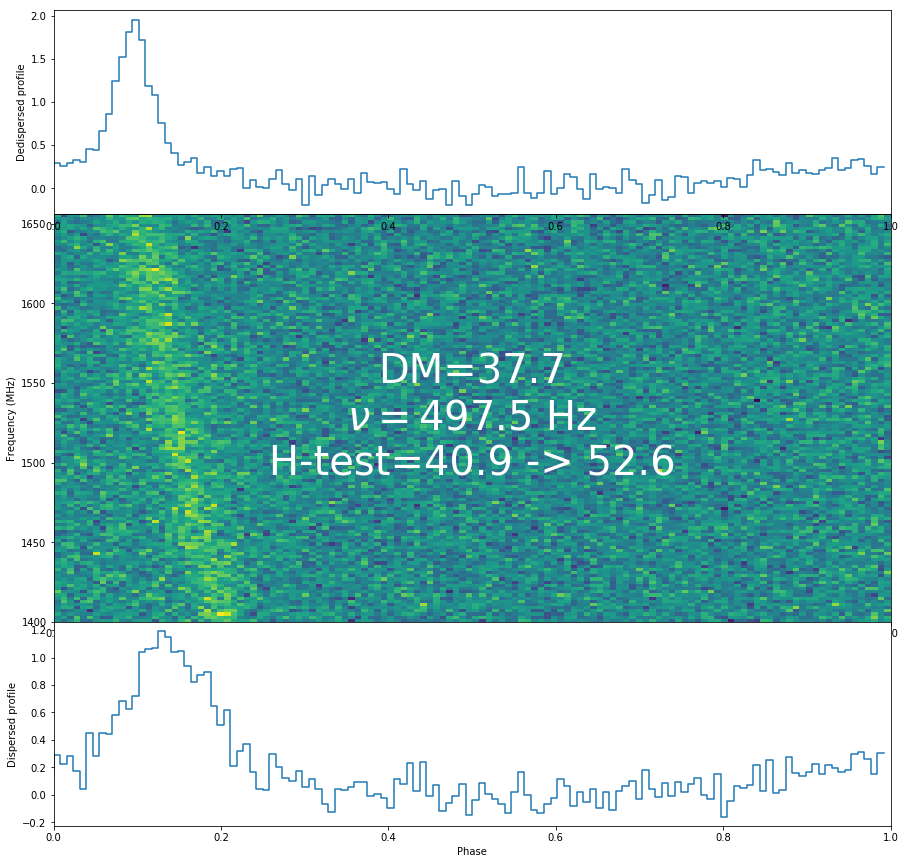

In [8]:
info = generate_dispersed_profile(pulse_freq=pulse_freq,
                                  start_freq=start_freq, 
                                  bandwidth=bandwidth,
                                  noise_level=1,
                                  ph0=0.1, width=0.03)
plot_profile(info)
print_info_to_table(info)

noise_level,nbin,ph0,width,amp,dm,nchan,bandwidth,start_freq,pulse_freq,dedisp_profile [128],"allprofs [128,128]",disp_profile [128],disp_z2,disp_z6,disp_z12,disp_z20,disp_H,dedisp_z2,dedisp_z6,dedisp_z12,dedisp_z20,dedisp_H
int64,int64,float64,float64,float64,float64,int64,int64,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
1,128,0.1,0.03,0.7501584038753625,480.54039222618763,128,256,1400,160.14530053990651,-0.09696344984095748 .. 0.08095789817240663,-0.0020364065925083754 .. -0.0077395099413038095,0.00591601798655071 .. 0.04019078517859958,19.87824625373509,20.40860269277616,20.64378259338789,20.973158594330442,15.730953757857623,45.82540615615508,59.548736001551816,64.2580077463128,65.18978704775239,44.55819319235273


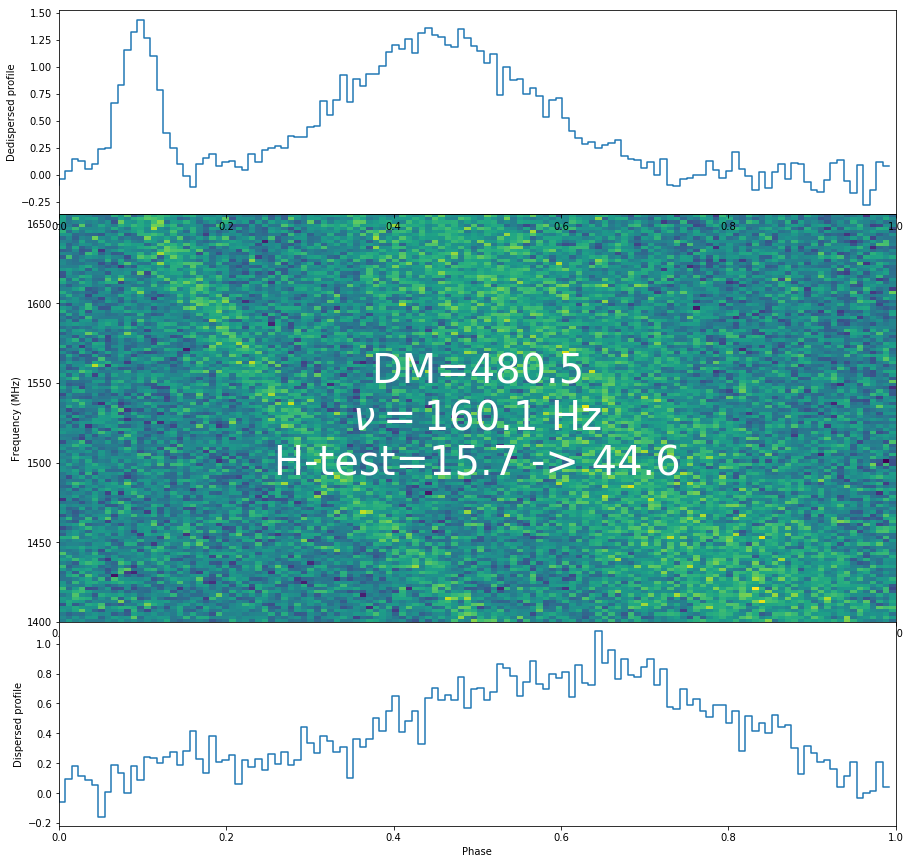

In [9]:
info = generate_dispersed_profile(pulse_freq=pulse_freq,
                                  start_freq=start_freq, 
                                  bandwidth=bandwidth,
                                  noise_level=1,
                                  ph0=0.1, width=0.03)
plot_profile(info)
print_info_to_table(info)

## Generate MAAANY profiles

In [10]:
def generate_maaaaany_profiles(maaaany=100):
    from astropy.table import vstack
    for i in range(maaaany):
        pulse_freq = np.random.uniform(100, 700)
        start_freq = np.random.uniform(700, 2500)
        bandwidth = np.random.choice([512, 1024])
        noise_level = np.random.uniform(0, 1)
        info = generate_dispersed_profile(pulse_freq=pulse_freq,
                                      start_freq=start_freq, 
                                      bandwidth=bandwidth,
                                      noise_level=1)
        if i == 0:
            table = print_info_to_table(info)
        else:
            table = vstack([table, print_info_to_table(info)])
    return table

In [11]:
table = generate_maaaaany_profiles(10)

In [12]:
table

noise_level,nbin,ph0,width,amp,dm,nchan,bandwidth,start_freq,pulse_freq,dedisp_profile [128],"allprofs [128,128]",disp_profile [128],disp_z2,disp_z6,disp_z12,disp_z20,disp_H,dedisp_z2,dedisp_z6,dedisp_z12,dedisp_z20,dedisp_H
int64,int64,float64,float64,float64,float64,int64,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
1,128,0.024511304669599387,0.02047255073992576,0.3754664518723786,406.48294137563784,128,512,1628.8860228920003,529.1001922366204,0.22233846624456347 .. 0.06503942866756489,0.011187811877774194 .. 0.0009400369647633085,0.05763828048564139 .. -0.022056852349383697,0.5162557032894219,2.359198339426266,3.0896729031200962,5.837323687625866,-2.91837379841926,10.666705952537757,23.165020464878946,34.22651081017717,40.720090356383466,5.493767716200445
1,128,0.26286362286797327,0.11614695096596005,0.6195288310001692,166.02190724654554,128,512,812.170758564556,636.8770074101006,0.6949525302987849 .. 0.8016515385404267,0.0028551262072110243 .. 0.007689979482688933,0.5824531276123684 .. 0.7203536194811918,0.15021388939152425,0.2654871916108487,0.4551158695785128,0.6372527421222265,-2.9508962236689382,27.681064221925617,32.61222884271092,32.753653560367006,32.960194544201634,22.886615614708234
1,128,0.27932977130452696,0.17583878070711656,0.6688141108734604,213.9929896707165,128,512,1179.8998919601058,488.01433505533464,0.9516420111086241 .. 0.9648984696806324,-0.001610143111899305 .. -0.0033583968417345705,0.8682369203617704 .. 0.7723033349721896,1.6615481504455207,1.8274732026918752,1.8909893853816948,2.0718254198164114,-1.4392913725022982,29.474955025994756,29.998956230127593,30.124332703839585,30.41097976795696,23.474955025994756
1,128,0.12107215303482777,0.18104402202858355,0.7778317205192169,474.8464919608976,128,1024,1508.2831617949573,304.1793418927274,1.0074327901824622 .. 0.8227554212834223,-0.0017136107439680562 .. 0.005398227056350952,0.3587092509563294 .. 0.4135658552377491,2.308255409417051,2.42096069020225,2.54834433264521,2.762907811656767,-0.8447948231286118,45.26250247238663,46.20104354504443,46.329858790516035,46.5398324903326,39.26250247238663
1,128,0.3170229506619857,0.09831460216336786,0.9544868467009454,219.06778100550866,128,512,1644.269233421347,310.74368573280617,1.362797186868708 .. 1.1733028133861203,0.003265633847086461 .. 0.008294705586359865,0.6332171134487738 .. 0.38638175089689736,31.10934808411326,31.490207440915956,31.586161077598607,31.74267170193911,27.306627199825655,53.87767019524096,63.978625668574004,64.07128549884766,64.29967983477671,52.585299997503164
1,128,0.32308266611508885,0.18442823856640206,0.9210825379680557,14.633358429395892,128,1024,2020.1476283313757,447.24085847517955,0.26881763657552854 .. 0.1412332485684274,-0.01950464954224813 .. -0.008187429149657458,0.1817619940271923 .. -0.0012295259942151637,105.9926632316654,106.46449538020276,106.53300132888752,106.67561524126866,99.9926632316654,106.63565473478621,107.16640017175459,107.24484254532727,107.44217995603297,100.63565473478621
1,128,0.9929584744874503,0.15002917426309212,0.6315917672805853,494.2999259371249,128,512,2353.156342098124,195.00495958423568,1.3121328965482006 .. 1.2672498935677585,0.01223175809557851 .. 0.011377705667140366,0.911571014950288 .. 0.7822490732832492,37.22809058431689,39.394144662253915,39.832398538299955,40.00693916328901,31.228090584316888,42.991746151638516,53.36256379894954,53.66856651614471,54.01934889890795,41.22036137268692
1,128,0.5542250985826382,0.10497400470635952,0.7630609583987599,89.61454044978117,128,1024,1748.9918453576704,273.7105241888118,-0.04647909700127297 .. -0.09727419585300356,-0.005891945385899245 .. 0.002768123103648715,-0.018148669064343616 .. -0.040109083410199246,84.98521029823704,88.93679550214239,89.076756440781,89.2393378760022,79.40731008385312,101.18479503850172,111.97657683403325,112.16117320372977,112.59856611784123,100.83515486119968
1,128,0.49029102111636913,0.13125012601790

### Read/write in HDF5 format

In [14]:
table.write("table.hdf5", path="fakepulsars")

In [17]:
Table.read("table.hdf5")

noise_level,nbin,ph0,width,amp,dm,nchan,bandwidth,start_freq,pulse_freq,dedisp_profile [128],"allprofs [128,128]",disp_profile [128],disp_z2,disp_z6,disp_z12,disp_z20,disp_H,dedisp_z2,dedisp_z6,dedisp_z12,dedisp_z20,dedisp_H
int64,int64,float64,float64,float64,float64,int64,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
1,128,0.024511304669599387,0.02047255073992576,0.3754664518723786,406.48294137563784,128,512,1628.8860228920003,529.1001922366204,0.22233846624456347 .. 0.06503942866756489,0.011187811877774194 .. 0.0009400369647633085,0.05763828048564139 .. -0.022056852349383697,0.5162557032894219,2.359198339426266,3.0896729031200962,5.837323687625866,-2.91837379841926,10.666705952537757,23.165020464878946,34.22651081017717,40.720090356383466,5.493767716200445
1,128,0.26286362286797327,0.11614695096596005,0.6195288310001692,166.02190724654554,128,512,812.170758564556,636.8770074101006,0.6949525302987849 .. 0.8016515385404267,0.0028551262072110243 .. 0.007689979482688933,0.5824531276123684 .. 0.7203536194811918,0.15021388939152425,0.2654871916108487,0.4551158695785128,0.6372527421222265,-2.9508962236689382,27.681064221925617,32.61222884271092,32.753653560367006,32.960194544201634,22.886615614708234
1,128,0.27932977130452696,0.17583878070711656,0.6688141108734604,213.9929896707165,128,512,1179.8998919601058,488.01433505533464,0.9516420111086241 .. 0.9648984696806324,-0.001610143111899305 .. -0.0033583968417345705,0.8682369203617704 .. 0.7723033349721896,1.6615481504455207,1.8274732026918752,1.8909893853816948,2.0718254198164114,-1.4392913725022982,29.474955025994756,29.998956230127593,30.124332703839585,30.41097976795696,23.474955025994756
1,128,0.12107215303482777,0.18104402202858355,0.7778317205192169,474.8464919608976,128,1024,1508.2831617949573,304.1793418927274,1.0074327901824622 .. 0.8227554212834223,-0.0017136107439680562 .. 0.005398227056350952,0.3587092509563294 .. 0.4135658552377491,2.308255409417051,2.42096069020225,2.54834433264521,2.762907811656767,-0.8447948231286118,45.26250247238663,46.20104354504443,46.329858790516035,46.5398324903326,39.26250247238663
1,128,0.3170229506619857,0.09831460216336786,0.9544868467009454,219.06778100550866,128,512,1644.269233421347,310.74368573280617,1.362797186868708 .. 1.1733028133861203,0.003265633847086461 .. 0.008294705586359865,0.6332171134487738 .. 0.38638175089689736,31.10934808411326,31.490207440915956,31.586161077598607,31.74267170193911,27.306627199825655,53.87767019524096,63.978625668574004,64.07128549884766,64.29967983477671,52.585299997503164
1,128,0.32308266611508885,0.18442823856640206,0.9210825379680557,14.633358429395892,128,1024,2020.1476283313757,447.24085847517955,0.26881763657552854 .. 0.1412332485684274,-0.01950464954224813 .. -0.008187429149657458,0.1817619940271923 .. -0.0012295259942151637,105.9926632316654,106.46449538020276,106.53300132888752,106.67561524126866,99.9926632316654,106.63565473478621,107.16640017175459,107.24484254532727,107.44217995603297,100.63565473478621
1,128,0.9929584744874503,0.15002917426309212,0.6315917672805853,494.2999259371249,128,512,2353.156342098124,195.00495958423568,1.3121328965482006 .. 1.2672498935677585,0.01223175809557851 .. 0.011377705667140366,0.911571014950288 .. 0.7822490732832492,37.22809058431689,39.394144662253915,39.832398538299955,40.00693916328901,31.228090584316888,42.991746151638516,53.36256379894954,53.66856651614471,54.01934889890795,41.22036137268692
1,128,0.5542250985826382,0.10497400470635952,0.7630609583987599,89.61454044978117,128,1024,1748.9918453576704,273.7105241888118,-0.04647909700127297 .. -0.09727419585300356,-0.005891945385899245 .. 0.002768123103648715,-0.018148669064343616 .. -0.040109083410199246,84.98521029823704,88.93679550214239,89.076756440781,89.2393378760022,79.40731008385312,101.18479503850172,111.97657683403325,112.16117320372977,112.59856611784123,100.83515486119968
1,128,0.49029102111636913,0.13125012601790